In [ ]:
import os
import sys
import subprocess
import pkg_resources


def get_sagemaker_version():
    "Return the version of 'sagemaker' in your kernel or -1 if 'sagemaker' is not installed"
    for i in pkg_resources.working_set:
        if i.key == "sagemaker":
            return "%s==%s" % (i.key, i.version)
    return -1


# Store original 'sagemaker' version
sagemaker_version = get_sagemaker_version()

# Install any missing dependencies
!{sys.executable} -m pip install -qU 'plotly' 'sagemaker>=2.84.0'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
import pickle
import ast
import plotly.express as px
import plotly.offline as pyo
import plotly.graph_objs as go

from sklearn.datasets import *
import sklearn.model_selection
from sklearn.datasets import make_regression
import sklearn.model_selection
from sklearn.neighbors import KNeighborsRegressor
from sklearn.inspection import permutation_importance

!{sys.executable} -m pip install -qU 'xgboost'
import xgboost
from xgboost import XGBRegressor

# SageMaker dependencies
import sagemaker
from sagemaker import get_execution_role
from sagemaker.inputs import TrainingInput
from sagemaker.image_uris import retrieve

# This instantiates a SageMaker session that we will be operating in.
session = sagemaker.Session()

# This object represents the IAM role that we are assigned.
role = sagemaker.get_execution_role()
print(role)

In [5]:
data_sets = {"diabetes": "load_diabetes()", "california": "fetch_california_housing()"}

In [6]:
choosen_data_set = "california"
assert choosen_data_set in data_sets.keys()
print("I selected the '{}' dataset!".format(choosen_data_set))

I selected the 'california' dataset!


In [7]:
data_set = eval(data_sets[choosen_data_set])

X = pd.DataFrame(data_set.data, columns=data_set.feature_names)
Y = pd.DataFrame(data_set.target)

print("Features:", list(X.columns))
print("Dataset shape:", X.shape)
print("Dataset Type:", type(X))
print("Label set shape:", Y.shape)
print("Label set Type:", type(X))

Features: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
Dataset shape: (20640, 8)
Dataset Type: <class 'pandas.core.frame.DataFrame'>
Label set shape: (20640, 1)
Label set Type: <class 'pandas.core.frame.DataFrame'>


In [10]:
df = pd.concat([X,Y],axis=1)

In [11]:
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,0
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [14]:
df.rename(columns={0:'target'},inplace=True)

In [17]:
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [18]:
X.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000


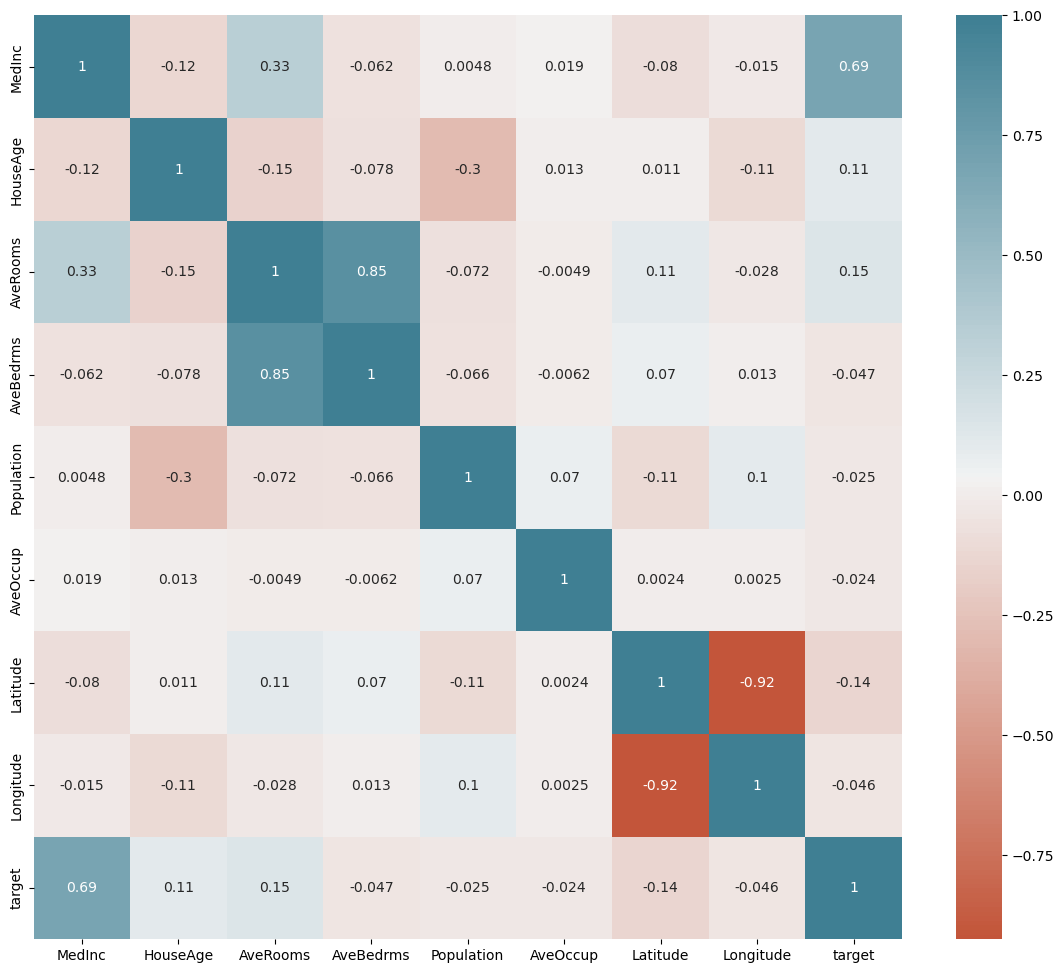

In [19]:
plt.figure(figsize=(14, 12))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=sns.diverging_palette(20, 220, n=200))
plt.show()

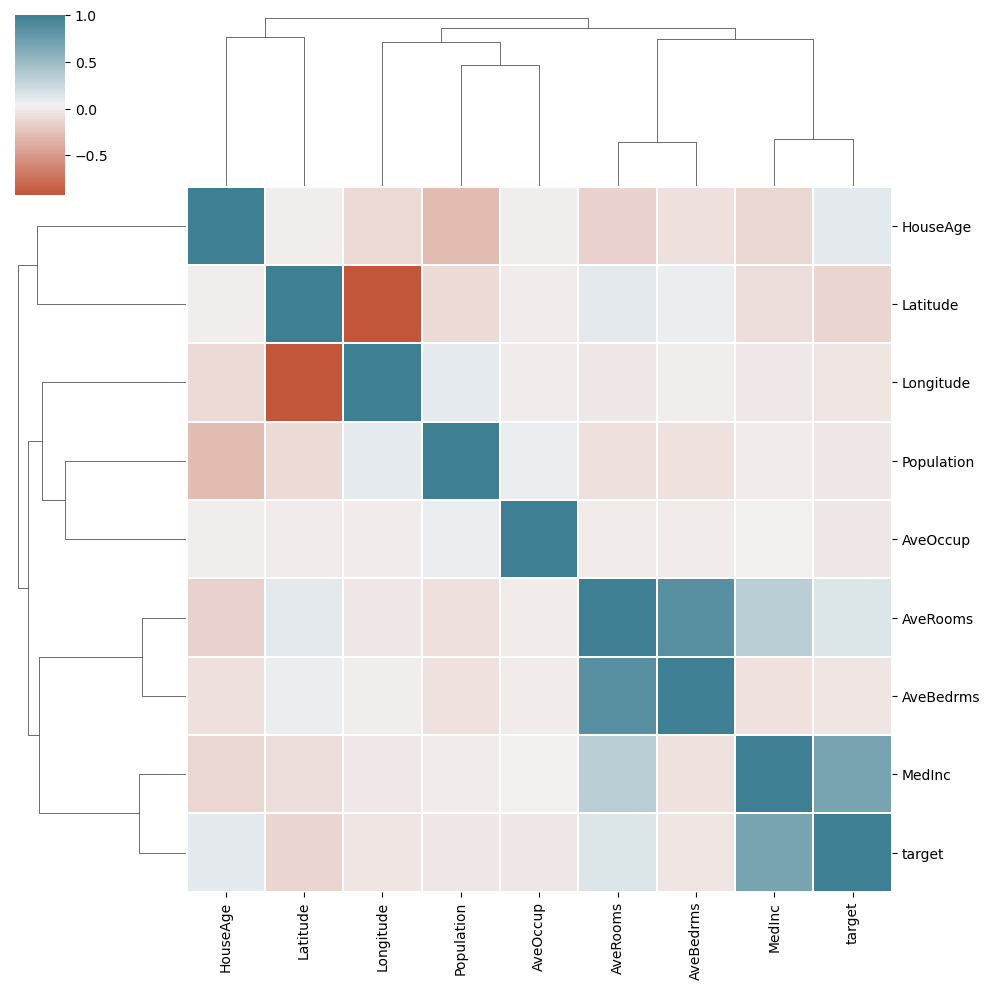

In [20]:
cluster_map = sns.clustermap(cor, cmap=sns.diverging_palette(20, 220, n=200), linewidths=0.1)
plt.setp(cluster_map.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
cluster_map

In [21]:
# We partition the dataset into 2/3 training and 1/3 test set.
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X, Y, test_size=0.33)

# We further split the training set into a validation set i.e., 2/3 training set, and 1/3 validation set
X_train, X_val, Y_train, Y_val = sklearn.model_selection.train_test_split(
    X_train, Y_train, test_size=0.33
)

In [22]:
X_data, y_label = make_regression(
    n_samples=X_train.shape[0], n_features=X_train.shape[1], n_informative=10, random_state=1
)
xgboost_model = XGBRegressor()
xgboost_model.fit(X_data, y_label)

feature_importances_xgboost = xgboost_model.feature_importances_
for index, importance_score in enumerate(feature_importances_xgboost):
    print("Feature: {}, Score: {}".format(X_train.columns[index], importance_score))

Feature: MedInc, Score: 0.15627290308475494
Feature: HouseAge, Score: 0.10350557416677475
Feature: AveRooms, Score: 0.20770636200904846
Feature: AveBedrms, Score: 0.32563668489456177
Feature: Population, Score: 0.0033104175236076117
Feature: AveOccup, Score: 0.015600369311869144
Feature: Latitude, Score: 0.02936643734574318
Feature: Longitude, Score: 0.1586012989282608


<p>This makes sense</p>

In [27]:
def create_bar_plot(feature_importances, X_train):
    """
    Create a bar plot of features against their corresponding feature importance score.
    """
    x_indices = [_ for _ in range(len(feature_importances))]
    plt.figure(figsize=(10, 3))
    plt.bar(x_indices, feature_importances, color="blue")
    plt.xticks(x_indices, X_train.columns)
    plt.xlabel("Feature", fontsize=18)
    plt.ylabel("Importance Score", fontsize=18)
    plt.title("Feature Importance Scores", fontsize=18)
    plt.show()

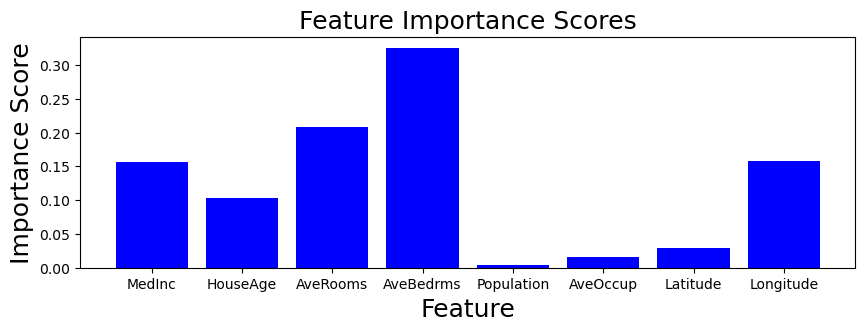

In [28]:

create_bar_plot(feature_importances_xgboost, X_train)


In [29]:
def show_ranked_feature_importance_list(scores, data):
    """
    Prints the features ranked by their corresponding importance score.
    """
    lst = list(zip(data.columns, scores))
    ranked_lst = sorted(lst, key=lambda t: t[1], reverse=True)
    print(pd.DataFrame(ranked_lst, columns=["Feature", "Importance Score"]))

In [30]:
show_ranked_feature_importance_list(feature_importances_xgboost, X_train)

      Feature  Importance Score
0   AveBedrms          0.325637
1    AveRooms          0.207706
2   Longitude          0.158601
3      MedInc          0.156273
4    HouseAge          0.103506
5    Latitude          0.029366
6    AveOccup          0.015600
7  Population          0.003310


<h2>Train using sagemaker</p>

In [32]:
data_dir = "../data/" + choosen_data_set
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

prefix = choosen_data_set + "-deploy-hl"
pd.concat([Y_train, X_train], axis=1).to_csv(
    os.path.join(data_dir, "train.csv"), header=False, index=False
)
pd.concat([Y_val, X_val], axis=1).to_csv(
    os.path.join(data_dir, "validation.csv"), header=False, index=False
)

val_location = session.upload_data(os.path.join(data_dir, "validation.csv"), key_prefix=prefix)
train_location = session.upload_data(os.path.join(data_dir, "train.csv"), key_prefix=prefix)

In [34]:
s3_input_train = TrainingInput(s3_data=train_location, content_type="text/csv")
s3_input_validation = TrainingInput(s3_data=val_location, content_type="text/csv")

In [42]:
container = retrieve(framework="xgboost", region=session.boto_region_name, version="1.7-1")

model = sagemaker.estimator.Estimator(
    container,
    role,
    instance_count=1,
    instance_type="ml.m6i.large",
    output_path="s3://{}/{}/output".format(session.default_bucket(), prefix),
    sagemaker_session=session,
)

INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


In [43]:
model.set_hyperparameters(
        max_depth=5,
        eta=0.2,
        gamma=4,
        min_child_weight=6,
        subsample=0.8,
        objective="reg:linear",
        early_stopping_rounds=10,
        num_round=1,
    )

In [ ]:
model.fit({"train": s3_input_train, "validation": s3_input_validation}, wait=True)

In [ ]:
sagemaker.s3.S3Downloader.download(s3_uri=model.model_data, local_path="./")